In [4]:
import os
from pathlib import Path
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
from dotenv import load_dotenv
from utils import generate_url_path
load_dotenv('../.env')

from utils import unify_coordinates_referential

data = pd.read_csv(generate_url_path(os.getenv('DATA_FOLDER'), use_posix=True) +  "/clean_data.csv")
print('Dataframe Columns :', data.columns,'DataFrame shape : ' ,data.shape, 'Dataframe Columns types:',data.dtypes,sep="\n\n")
data.head()

Dataframe Columns :

Index(['gameId', 'season', 'gameType', 'gameDate', 'homeTeam', 'awayTeam',
       'rinkSide', 'period', 'periodTime', 'byTeam', 'eventType', 'shotType',
       'coordinateX', 'coordinateY', 'shooterName', 'goalieName', 'strength',
       'emptyNet'],
      dtype='object')

DataFrame shape : 

(387829, 18)

Dataframe Columns types:

gameId           int64
season           int64
gameType        object
gameDate        object
homeTeam        object
awayTeam        object
rinkSide        object
period           int64
periodTime      object
byTeam          object
eventType       object
shotType        object
coordinateX    float64
coordinateY    float64
shooterName     object
goalieName      object
strength        object
emptyNet          bool
dtype: object


,gameId,season,gameType,gameDate,homeTeam,awayTeam,rinkSide,period,periodTime,byTeam,eventType,shotType,coordinateX,coordinateY,shooterName,goalieName,strength,emptyNet
0,2016020001,2016,R,2016-10-12,OTT,TOR,right,1,01:11,TOR,SHOT,Wrist Shot,-77.0,5.0,Mitchell Marner,Craig Anderson,NaN,False
1,2016020001,2016,R,2016-10-12,OTT,TOR,left,1,02:53,OTT,SHOT,Wrist Shot,86.0,13.0,Chris Kelly,Frederik Andersen,NaN,False
2,2016020001,2016,R,2016-10-12,OTT,TOR,left,1,04:01,OTT,SHOT,Wrist Shot,23.0,-38.0,Cody Ceci,Frederik Andersen,NaN,False
3,2016020001,2016,R,2016-10-12,OTT,TOR,left,1,04:46,OTT,SHOT,Slap Shot,33.0,-15.0,Erik Karlsson,Frederik Andersen,NaN,False
4,2016020001,2016,R,2016-10-12,OTT,TOR,right,1,06:46,TOR,SHOT,Wrist Shot,-34.0,28.0,Martin Marincin,Craig Anderson,NaN,False


# Comparaison des types de tirs: Total de tirs vs Buts

In [2]:
# Filtering for the shots and goals events
shots_data = data[data['season'] == 2020]

# Grouping by shotType and counting the number of shots and goals
shot_counts = shots_data.groupby('shotType').eventType.value_counts().unstack().fillna(0)

# Sorting by total shots for better visualization
shot_counts['TotalShots'] = shot_counts['SHOT'] + shot_counts['GOAL']
shot_counts = shot_counts.sort_values(by='TotalShots', ascending=False)

# Calculating the percentage of shots that are goals
shot_counts['GoalPercentage'] = (shot_counts['GOAL'] / shot_counts['TotalShots']) * 100

shot_counts

eventType,GOAL,SHOT,TotalShots,GoalPercentage
shotType,,,,
Wrist Shot,2998,29973,32971,9.092839
Slap Shot,560,7422,7982,7.015786
Snap Shot,812,6988,7800,10.410256
Backhand,538,3915,4453,12.081743
Tip-In,504,2293,2797,18.019306
Deflected,182,986,1168,15.582192
Wrap-around,38,521,559,6.797853


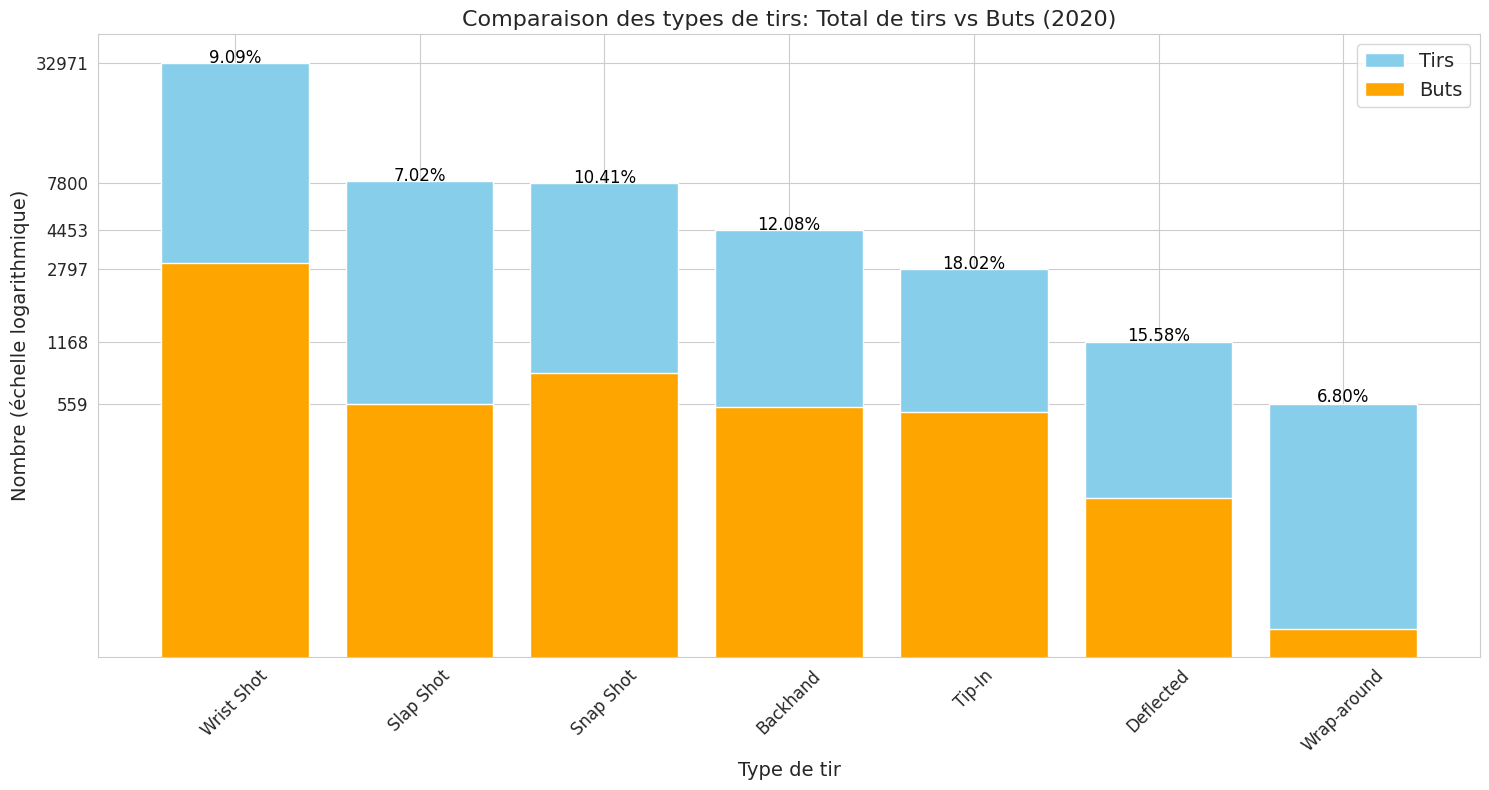

In [3]:
plt.figure(figsize=(15, 8))
sns.set_style("whitegrid")

bars = plt.bar(shot_counts.index, shot_counts['TotalShots'], label='Tirs', color='skyblue')

plt.bar(shot_counts.index, shot_counts['GOAL'], label='Buts', color='orange')

for i, bar in enumerate(bars):
    plt.text(bar.get_x() + bar.get_width() / 2,  
             bar.get_height() + 10, 
             f"{shot_counts['GoalPercentage'].iloc[i]:.2f}%",
             ha='center', color='black', fontsize=12) 

plt.ylabel('Nombre (échelle logarithmique)', fontsize=14)
plt.xlabel('Type de tir', fontsize=14)
plt.yscale('log')
plt.yticks(shot_counts['TotalShots'].drop('Slap Shot'), shot_counts['TotalShots'].drop('Slap Shot'), fontsize=12)
plt.title('Comparaison des types de tirs: Total de tirs vs Buts (2020)', fontsize=16)
plt.legend(fontsize=14)
plt.xticks(fontsize=12, rotation=45)

plt.tight_layout()
plt.show()

Lorsque nous examinons le graphique présentant une comparaison entre le nombre total de tirs (en bleu) et le nombre de buts (en orange) pour différents types de tirs lors de la saison 2020, plusieurs points clés ressortent. Tout d'abord, le "Wrist Shot" se distingue comme le type de tir le plus courant, affichant le plus grand nombre de tentatives. C'est probablement dû au fait que le "Wrist Shot" est un tir fondamental dans le monde du hockey, privilégié pour sa rapidité de déclenchement et sa précision. Cependant, si l'on évalue la dangerosité d'un tir en fonction du rapport entre le nombre de buts marqués et le nombre total de tirs, le "Tip In" se révèle être le plus efficace, avec un taux de conversion impressionnant de 18,02%. La nature imprévisible de ces tirs déviés à la dernière seconde pourrait expliquer pourquoi ils sont si redoutables pour les gardiens de but.

Quant au choix du graphique à barres superposées, il s'est avéré être particulièrement éclairant. Il offre une comparaison directe et visuellement claire, renforcée par l'utilisation de couleurs distinctes pour les tirs et les buts. L'échelle logarithmique, quant à elle, est efficace pour mettre en évidence les différences, même pour les types de tirs qui ont un nombre plus faible de tentatives et de buts.

# Relation entre la distance à laquelle un tir a été effectué et la chance qu'il s'agisse d'un but

In [4]:
data_coords_unified = unify_coordinates_referential(data)

goal_position = np.array([89, 0])

data["distance"] = np.sqrt(np.sum(np.square(data_coords_unified[['coordinateX', 'coordinateY']] - goal_position), axis=1))

In [5]:
seasons_data = data[data['season'].isin([2018, 2019, 2020])]

bin_edges = np.linspace(0, 100, 21)  

seasons = [2018, 2019, 2020]
goal_probabilities = {}

for season in seasons:
    
    season_data = seasons_data[seasons_data['season'] == season].copy()
    
    season_data.loc[:, 'distance_bin'] = pd.cut(season_data['distance'], bins=bin_edges)
    
    goal_prob = season_data.groupby('distance_bin', observed=True).apply(lambda x: (x['eventType'] == 'GOAL').sum() / len(x))
    goal_probabilities[season] = goal_prob

goal_probabilities[2018]

distance_bin
(0.0, 5.0]       0.300792
(5.0, 10.0]      0.184506
(10.0, 15.0]     0.166683
(15.0, 20.0]     0.154463
(20.0, 25.0]     0.124311
(25.0, 30.0]     0.113870
(30.0, 35.0]     0.085684
(35.0, 40.0]     0.061242
(40.0, 45.0]     0.046460
(45.0, 50.0]     0.038931
(50.0, 55.0]     0.031909
(55.0, 60.0]     0.030751
(60.0, 65.0]     0.025389
(65.0, 70.0]     0.020906
(70.0, 75.0]     0.027027
(75.0, 80.0]     0.036072
(80.0, 85.0]     0.033408
(85.0, 90.0]     0.029630
(90.0, 95.0]     0.051988
(95.0, 100.0]    0.027322
dtype: float64

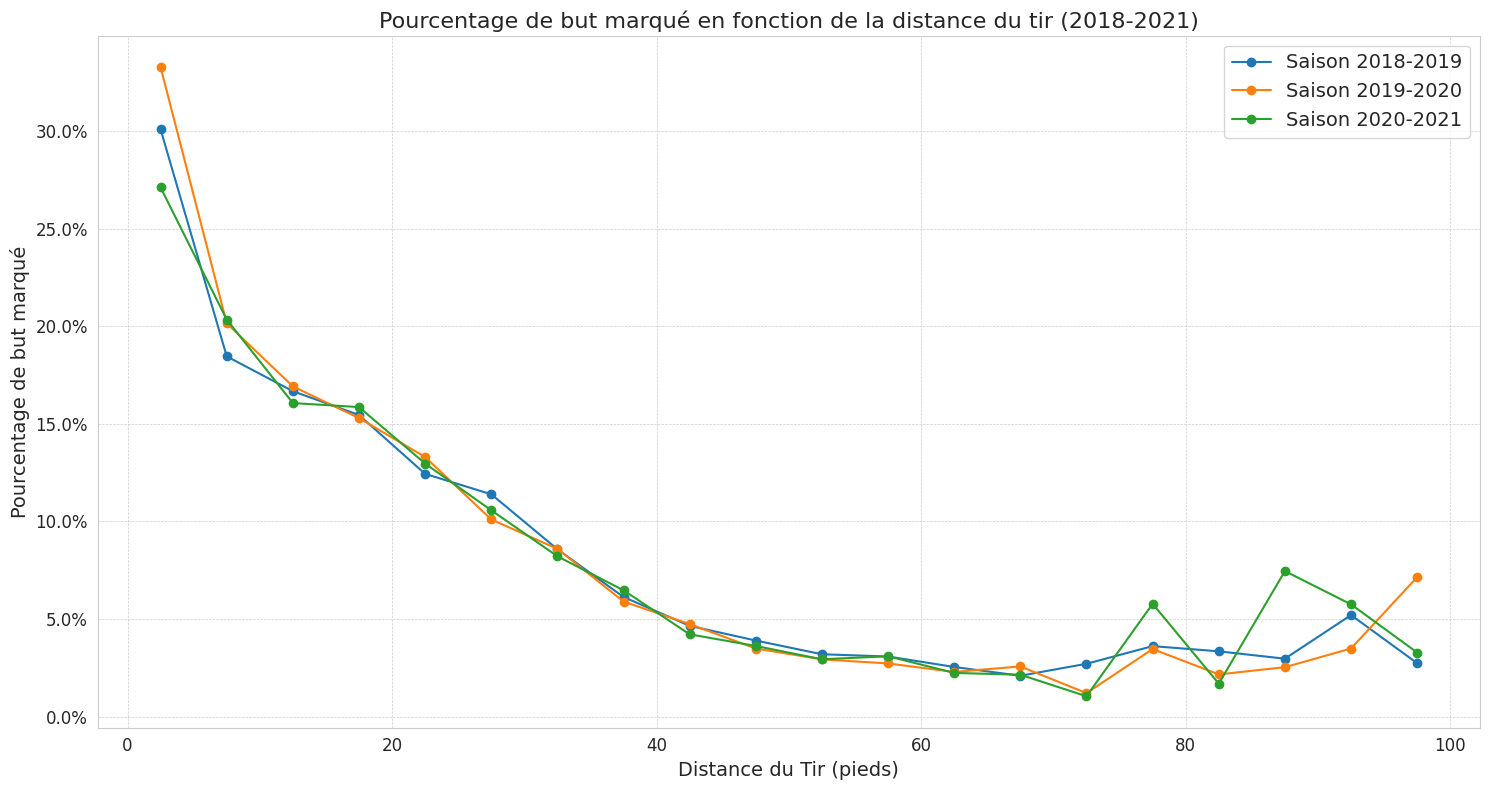

In [6]:
plt.figure(figsize=(15, 8))

for season, probs in goal_probabilities.items():
    plt.plot(probs.index.categories.mid, probs, label=f'Saison {season}-{season+1}', marker='o')

plt.title('Pourcentage de but marqué en fonction de la distance du tir (2018-2021)', fontsize=16)
plt.xlabel('Distance du Tir (pieds)', fontsize=14)
plt.ylabel('Pourcentage de but marqué', fontsize=14)
plt.legend(fontsize=14)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))  
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()

plt.show()


De manière générale, on observe que plus la distance du tir est grande, plus la probabilité de marquer un but est faible. C'est une observation logique car il est naturellement plus difficile de marquer depuis une position éloignée. Les tirs effectués à très courte distance (0-5m) présentent la plus haute probabilité de se transformer en but, souvent supérieure à 25%. Cette probabilité décroît assez régulièrement jusqu'à une distance d'environ 40m. Au-delà de cette distance, elle semble fluctuer davantage, possiblement à cause d'un nombre d'échantillons moins important pour les tirs longue distance, rendant les probabilités moins stables. Les trois saisons montrent des tendances assez similaires avec cependant de légères variations. Par exemple, la saison 2019-20 semble avoir une probabilité légèrement plus élevée de marquer à très courte distance comparativement aux deux autres saisons.

# Pourcentage de buts en fonction à la fois de la distance par rapport au filet et de la catégorie de types de tirs

In [7]:
season_data = data.copy()

season_data['distance_bin'] = pd.cut(season_data['distance'], bins=bin_edges)

goal_prob = season_data.groupby(['shotType', 'distance_bin'], observed=True).apply(lambda x: (x['eventType'] == 'GOAL').sum() / len(x))

goal_prob

shotType    distance_bin 
Backhand    (0.0, 5.0]       0.368932
            (5.0, 10.0]      0.177828
            (10.0, 15.0]     0.134809
            (15.0, 20.0]     0.083953
            (20.0, 25.0]     0.056777
                               ...   
Wrist Shot  (75.0, 80.0]     0.039246
            (80.0, 85.0]     0.034053
            (85.0, 90.0]     0.051518
            (90.0, 95.0]     0.056533
            (95.0, 100.0]    0.067114
Length: 134, dtype: float64

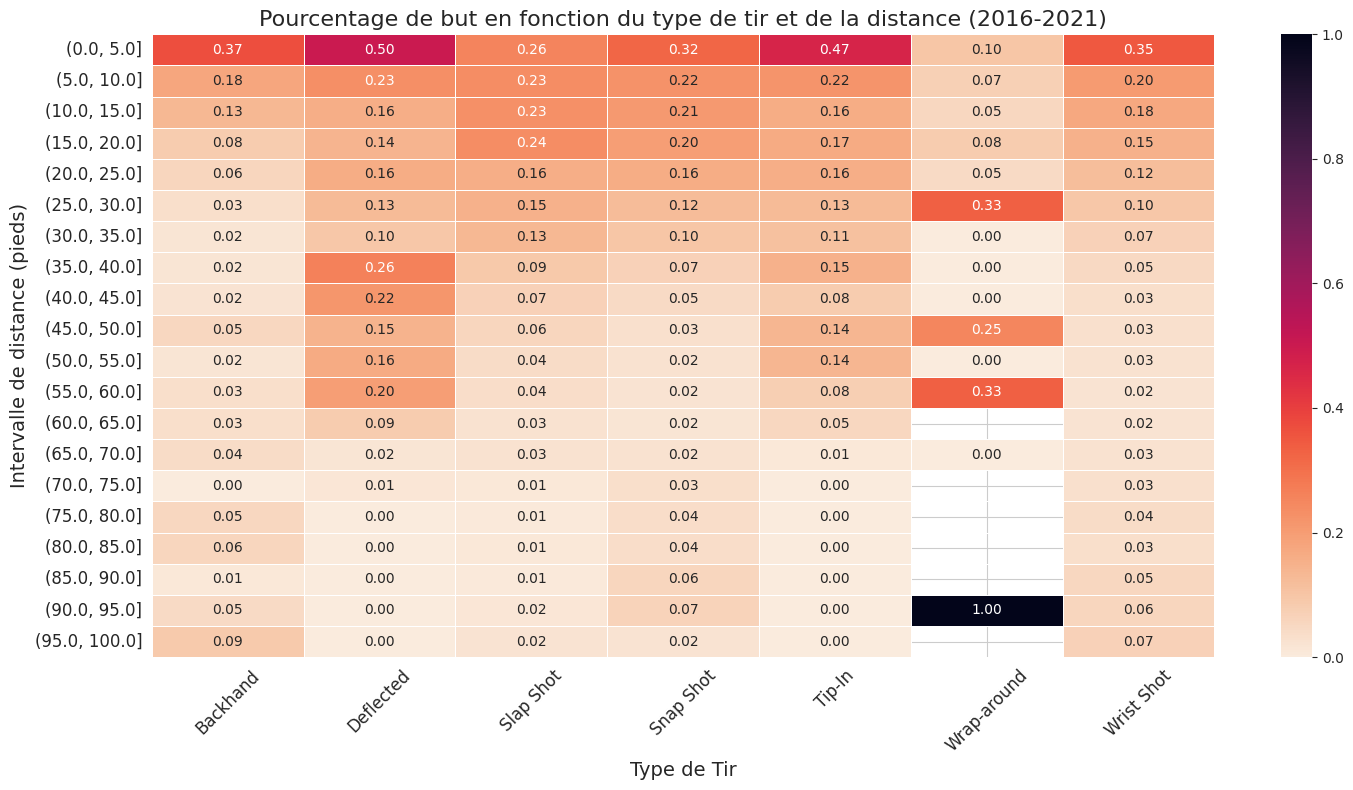

In [8]:
heatmap_data = goal_prob.unstack(level=0)

plt.figure(figsize=(15, 8))
sns.set_style("whitegrid")
cmap = sns.cm.rocket_r  
heatmap = sns.heatmap(heatmap_data, cmap=cmap, annot=True, fmt=".2f", linewidths=.5)
plt.title('Pourcentage de but en fonction du type de tir et de la distance (2016-2021)', fontsize=16)
plt.xlabel('Type de Tir', fontsize=14)
plt.ylabel('Intervalle de distance (pieds)', fontsize=14)
plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=12)

plt.tight_layout()
plt.show()